# DTW Evaluation

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import tikzplotlib
import random
import ast
import fastdtw
from scipy.spatial.distance import euclidean
from itertools import combinations
from lyrics_stats import lyrics_statistics
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [2]:
sns.set_theme(context='paper', style='white', palette='deep')

## DTW: The idea behind

In [3]:
def generate_uni_features_ts(lyrics):
    multi_ts = pd.DataFrame(lyrics_statistics(lyrics)).values
    ss = StandardScaler()
    multi_ts = ss.fit_transform(multi_ts)
    pca = PCA(n_components=1, random_state=0)
    uni_ts = np.array([pc[0] for pc in pca.fit_transform(multi_ts)])
    return uni_ts

In [4]:
eg_lyr = pd.read_csv('../data/toy-lyrics/toy_lyr.csv', sep='\t')
eg_similar_lyr = pd.read_csv('../data/toy-lyrics/toy_sim.csv', sep='\t')
eg_random_lyr = pd.read_csv('../data/toy-lyrics/toy_rnd.csv', sep='\t')

eg_lyrics = [eg_lyr, eg_similar_lyr, eg_random_lyr]

In [5]:
ts1, ts2, ts3 = [generate_uni_features_ts(list(lyr['lyrics'])) for lyr in eg_lyrics]

ts1_parts, ts2_parts, ts3_parts = [lyr['part'] for lyr in eg_lyrics]

color_map = {}
for idx, part_of_lyrics in enumerate(list(dict.fromkeys(ts1_parts))):    
    # Map color excluding first color of the palette 
    color_map[part_of_lyrics] = sns.color_palette()[idx+1]

In [6]:
sim_distance, warp_path = fastdtw.dtw(ts1, ts2)
print(f'DTW distance between similar lyrics: {sim_distance}')

rnd_distance = fastdtw.dtw(ts1, ts3)[0]
print(f'DTW distance between random lyrics: {rnd_distance}')

DTW distance between similar lyrics: 19.71522340995776
DTW distance between random lyrics: 37.70994555359612


In [7]:
ts2 = [10 + timestamp for timestamp in ts2] 

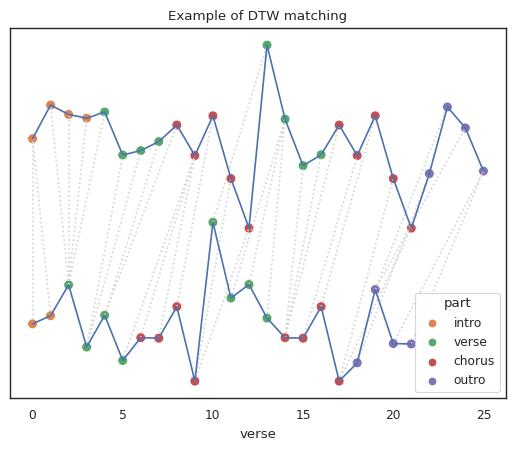

In [8]:
fig, ax = plt.subplots()

for [map_x, map_y] in warp_path:
    ax.plot([map_x, map_y], [ts1[map_x], ts2[map_y]], linestyle='dotted', color='lightgray')

plt.plot(ts1, color=sns.color_palette()[0]) 
plt.plot(ts2, color=sns.color_palette()[0])

sns.scatterplot(y=ts1, x=range(len(ts1)),
                hue=ts1_parts, s=50, palette=color_map)

sns.scatterplot(y=ts2, x=range(len(ts2)),
                hue=ts2_parts, s=50, palette=color_map, legend=False)


ax.set_yticklabels([])
ax.set_ylabel('')
ax.set_xlabel('verse')
ax.set_title('Example of DTW matching')
ax.tick_params(left=False)  # remove the ticks
tikzplotlib.save('../tikz/dtw_demo.tex')

In [9]:
def evaluate_ts_data(ts_type, normalize=True):    
    ts_data = pd.read_csv(f'../data/evaluation/time-series/{ts_type}.csv')
    for column in ts_data.columns:
        ts_data[column] = list(
            map(lambda x: np.array(ast.literal_eval(x)), ts_data[column]))
    if normalize:
        scaler = StandardScaler()            
        for column in ts_data.columns:
            ts_data[column] = list(
                map(lambda x: scaler.fit_transform(x.reshape(-1, 1)), ts_data[column]))    
    sim_dtw = [fastdtw.dtw(ts1, ts2)[0] for ts1, ts2 in zip(ts_data['lyrics'], ts_data['similar_lyrics'])]
    rnd_dtw = [fastdtw.dtw(ts1, ts2)[0] for ts1, ts2 in zip(ts_data['lyrics'], ts_data['random_lyrics'])]
    sim_closer = sum(1 for similar, random in zip(sim_dtw, rnd_dtw) if similar < random)
    rnd_closer = sum(1 for similar, random in zip(sim_dtw, rnd_dtw) if random < similar)
    similarity_score = sim_closer / (sim_closer + rnd_closer)        
    avg_sim_dtw = np.mean(sim_dtw)
    std_sim_dtw = np.std(sim_dtw)
    avg_rnd_dtw = np.mean(rnd_dtw)
    std_rnd_dtw = np.std(rnd_dtw)
    
    metrics = {'similarity score': similarity_score,                                  
               'avg sim distance': avg_sim_dtw,
               'std sim distance': std_sim_dtw,
               'avg rnd distance': avg_rnd_dtw,
               'std rnd distance': std_rnd_dtw
              }
    return metrics

In [10]:
metrics = {}

## Evaluation

**Features Time series**

In [11]:
ts_types = ['features_avg_ts', 'features_max_ts', 'features_pca_ts', 'features_gpca_ts']

for ts_type in ts_types:
    evaluation_result = evaluate_ts_data(ts_type, normalize=True)
    metrics[('features', ts_type.split('_')[1])] = evaluation_result

**Sentence BERT Time Series**

In [12]:
ts_types = ['sbert_avg_ts', 'sbert_max_ts', 'sbert_pca_ts', 'sbert_gpca_ts']

for ts_type in ts_types:
    evaluation_result = evaluate_ts_data(ts_type, normalize=True)
    metrics[('sbert', ts_type.split('_')[1])] = evaluation_result

**Doc2Vec Time Series**

In [13]:
ts_types = ['d2v_avg_ts', 'd2v_max_ts', 'd2v_pca_ts', 'd2v_gpca_ts']

for ts_type in ts_types:
    evaluation_result = evaluate_ts_data(ts_type, normalize=True)
    metrics[('doc2vec', ts_type.split('_')[1])] = evaluation_result

**Sentiment Time Series**

In [14]:
ts_types = ['sentibert_ts', 'sentivader_ts', 'sentiment_ts', 'emotion_ts']


for ts_type in ts_types:
    evaluation_result = evaluate_ts_data(ts_type, normalize=True)
    metrics[('sentiment', ts_type.split('_')[0])] = evaluation_result

In [15]:
df = pd.DataFrame(metrics).T
cols = [('similar pairs', 'similarity score'), 
        ('similar pairs', 'avg sim distance'), 
        ('similar pairs', 'std sim distance'),
        ('random pairs', 'avg rnd distance'), 
        ('random pairs', 'std rnd distance')]

df.columns = pd.MultiIndex.from_tuples(cols)

df = df.rename(columns={'avg sim distance': 'avg distance', 'avg rnd distance': 'avg distance', 
                        'std sim distance': 'std distance', 'std rnd distance': 'std distance'})

df.rename(index={'sentivader': 'vader', 'sentibert': 'roberta', 'sentiment': 'avg'}, level=1)

similar pairs                           random pairs  \
                  similarity score avg distance std distance avg distance   
features  avg             0.840000    26.966937    11.482092    38.858087   
          max             0.713333    29.920285    11.758540    36.563842   
          pca             0.633333    32.000396    19.084052    38.340218   
          gpca            0.986667    18.606106    11.589088    39.049564   
sbert     avg             0.666667    32.067426    13.367568    38.668533   
          max             0.693333    31.002776    13.415822    38.131634   
          pca             0.540000    36.285563    18.556170    36.899961   
          gpca            0.766667    28.800809    13.126740    38.672510   
doc2vec   avg             0.740000    30.603249    11.931334    38.333486   
          max             0.740000    29.727266    11.342604    36.990407   
          pca             0.593333    32.977797    15.485121    36.890311   
          gpca            0.720000    30.194319    11.870456    37.698848   
sentiment roberta         0.866667    27.776401    12.614006    41.820047   
          vader           0.800000    28.488779    13.663805    39.609612   
          avg             0.846667    28.897392    11.996349    39.586890   
          emotion         0.806667    29.185743    12.766013    38.779836   

                                
                  std distance  
features  avg        12.114070  
          max        11.185742  
          pca        11.843475  
          gpca       12.293117  
sbert     avg        12.335492  
          max        12.352845  
          pca        12.382750  
          gpca       12.732607  
doc2vec   avg        11.742226  
          max        11.766091  
          pca        12.210344  
          gpca       11.723299  
sentiment roberta    14.551711  
          vader      13.523310  
          avg        12.550292  
          emotion    12.823883

In [16]:
df.to_csv('../data/evaluation/metrics.csv', index=False)

In [17]:
# save the DataFrame to a LaTeX table format
with open('../data/evaluation/evaluation_table.tex', 'w') as f:
    f.write(df.round(2).to_latex())

/tmp/ipykernel_66048/2226788113.py:3: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  f.write(df.round(2).to_latex())


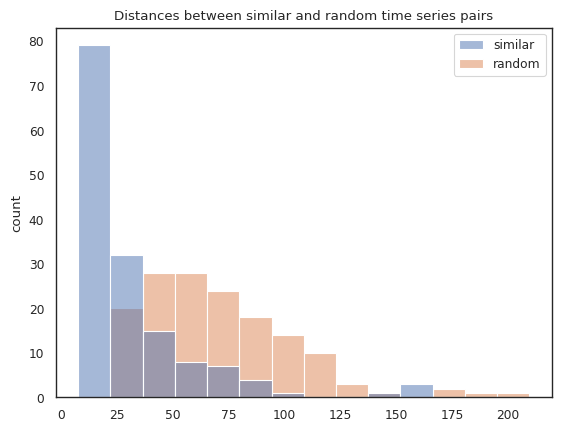

In [18]:
ts_type = 'features_gpca_ts'

ts_data = pd.read_csv(f'../data/evaluation/time-series/{ts_type}.csv')
for column in ts_data.columns:
    ts_data[column] = list(
        map(lambda x: np.array(ast.literal_eval(x)), ts_data[column]))
sim_dtw = [fastdtw.dtw(ts1, ts2)[0] for ts1, ts2 in zip(ts_data['lyrics'], ts_data['similar_lyrics'])]
rnd_dtw = [fastdtw.dtw(ts1, ts2)[0] for ts1, ts2 in zip(ts_data['lyrics'], ts_data['random_lyrics'])]

x = sim_dtw+rnd_dtw
h = (['similar'] * len(sim_dtw)) + (['random'] * len(rnd_dtw))

fig, ax = plt.subplots()
ax = sns.histplot(x=x, hue=h)
ax.set_title('Distances between similar and random time series pairs')
ax.set_ylabel('count')

tikzplotlib.save('../tikz/hist_eval_features_gpca.tex')